In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import pickle

from game import *
from agents import *
from checkers import *

In [2]:
n_features = 34
feature_func = checkers_features_augmented

reward_function = checkers_reward
reverse_reward_function = reverse_checkers_reward

activation_fn = lambda x: 1/(1+np.exp(-x))
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [128,64]
hidden_layers = len(width)
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': n_features,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

weight_shape = mlp = MLP(architecture).weights.shape

ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()
second_agent_list = [ab1, ab2, ab3, rand_agent]

ab1_r = AlphaBetaAgent(1, reward_direction=-1)
ab2_r = AlphaBetaAgent(2, reward_direction=-1)
ab3_r = AlphaBetaAgent(3, reward_direction=-1)        
second_agent_list_post_reversal = [ab1_r, ab2_r, ab3_r, rand_agent]

quiet = True
n_train_games = 1000
n_train_games_post_reversal = 1000
max_moves = 500
n_decay = 10
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3
gamma = 0.7
initial_alpha = 0.001
initial_epsilon = 0.5



In [3]:
pool_results = []
pool_draws = []
pool_oppn_idx = []
pool_weights = []
pool_rewards = []
pool_td = []
pool_num = []
pool_test_results_rand = []
pool_test_results_1 = []
pool_test_results_2 = []
pool_test_results_3 = []
pool_test_draws_rand = []
pool_test_draws_1 = []
pool_test_draws_2 = []
pool_test_draws_3 = []

for i_trial in range(10):
    # start with reverse rule
    reverse=True
    print('Trial =', i_trial)
    
    np.random.seed(i_trial)
    initial_weights = np.random.normal(size=weight_shape)
    first_agent = SarsaLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reverse_reward_function, 
                                     alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, 
                                     is_learning_agent=True, weights=initial_weights)

    all_results = []
    all_draws = []
    all_oppn_idx = []
    all_weights = []
    all_rewards = []
    all_td = []
    all_num = []
    test_results_rand = []
    test_results_1 = []
    test_results_2 = []
    test_results_3 = []
    test_draws_rand = []
    test_draws_1 = []
    test_draws_2 = []
    test_draws_3 = []

    # pre-training test
    this_test_results_rand = []
    this_test_results_1 = []
    this_test_results_2 = []
    this_test_results_3 = []

    this_test_draws_rand = []
    this_test_draws_1 = []
    this_test_draws_2 = []
    this_test_draws_3 = []

    for n in range(n_games_test):
        test_agent = SarsaLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reverse_reward_function, 
                                        alpha=0., gamma=gamma, epsilon=initial_epsilon, 
                                        is_learning_agent=False, weights=initial_weights)
        # play against ab1_r
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, ab1_r, first_agent_turn, quiet=quiet, reverse=reverse)

        # random start
        random_start_spots = game.game_state.board.spots
        for _ in range(np.random.choice(max_random_start_depth_test)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)
            random_start_spots = game.game_state.board.spots

        num_moves, game_state = game.run()
        this_test_results_1.append(game_state.is_first_agent_win())
        this_test_draws_1.append(game_state.max_moves_done)

        # play against ab2_r
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, ab2_r, first_agent_turn, quiet=quiet, reverse=reverse)
        game.game_state.board.spots = random_start_spots # set start board position to the same random start
        num_moves, game_state = game.run()
        this_test_results_2.append(game_state.is_first_agent_win())
        this_test_draws_2.append(game_state.max_moves_done)

        # play against ab3_r
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, ab3_r, first_agent_turn, quiet=quiet, reverse=reverse)
        game.game_state.board.spots = random_start_spots # set start board position to the same random start
        num_moves, game_state = game.run()
        this_test_results_3.append(game_state.is_first_agent_win())
        this_test_draws_3.append(game_state.max_moves_done)

        # play against random agent
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet, reverse=reverse)
        game.game_state.board.spots = random_start_spots # set start board position to the same random start
        num_moves, game_state = game.run()
        this_test_results_rand.append(game_state.is_first_agent_win())
        this_test_draws_rand.append(game_state.max_moves_done)

    test_results_1.append(np.mean(np.array(this_test_results_1)))
    test_results_2.append(np.mean(np.array(this_test_results_2)))
    test_results_3.append(np.mean(np.array(this_test_results_3)))
    test_results_rand.append(np.mean(np.array(this_test_results_rand)))

    test_draws_1.append(np.mean(np.array(this_test_draws_1)))
    test_draws_2.append(np.mean(np.array(this_test_draws_2)))
    test_draws_3.append(np.mean(np.array(this_test_draws_3)))
    test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))


    # training with reverse rule
    for n in range(n_train_games):    
        # change alpha and epsilon after n_decay games
        if n%n_decay == n_decay-1:
            first_agent.alpha = max([0.95*first_agent.alpha, 1e-5])
            first_agent.epsilon = max([0.95*first_agent.epsilon, 0.01])
#             print(n, 'Fraction of wins = ', np.mean(all_results[-n_decay:]), 'Fraction of draws = ', np.mean(all_draws[-n_decay:]))
#             print(n ,'alpha = ',first_agent.alpha, 'epsilon = ',first_agent.epsilon)

#         if n%50 == 0: print(n)
        # train against randomly selected agent
        first_agent_turn = bool(np.random.binomial(1,0.5))

        second_agent_idx = np.random.choice(len(second_agent_list_post_reversal))  
        all_oppn_idx.append(second_agent_idx)
        second_agent = second_agent_list_post_reversal[second_agent_idx]

        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet, reverse=reverse)    

        # random start
        for _ in range(np.random.choice(max_random_start_depth_train)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)

        num_moves, game_state = game.run()

        all_num.append(num_moves)
        all_rewards.append(first_agent.episode_rewards)
        all_td.append(first_agent.episode_td_history[-1])
        all_results.append(game_state.is_first_agent_win())
        all_draws.append((game_state.max_moves_done))
#         all_weights.append(first_agent.weights.copy())

        if n%test_frequency == test_frequency-1:

            this_test_results_rand = []
            this_test_results_1 = []
            this_test_results_2 = []
            this_test_results_3 = []

            this_test_draws_rand = []
            this_test_draws_1 = []
            this_test_draws_2 = []
            this_test_draws_3 = []

            for _ in range(n_games_test):
                current_epislon = first_agent.epsilon
                current_weights = first_agent.nn.weights.copy()
                test_agent = SarsaLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reverse_reward_function, 
                                                alpha=0., gamma=gamma, epsilon=current_epislon, 
                                                is_learning_agent=False, weights=current_weights)
                # play against ab1_r
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab1_r, first_agent_turn, quiet=quiet, reverse=reverse)

                # random start
                random_start_spots = game.game_state.board.spots
                for _ in range(np.random.choice(max_random_start_depth_test)*2):
                    possible_moves = game.game_state.board.get_possible_next_moves()
                    next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                    game.game_state.board.make_move(next_move, switch_player_turn=True)
                    random_start_spots = game.game_state.board.spots

                num_moves, game_state = game.run()
                this_test_results_1.append(game_state.is_first_agent_win())
                this_test_draws_1.append(game_state.max_moves_done)

                # play against ab2_r
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab2_r, first_agent_turn, quiet=quiet, reverse=reverse)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_2.append(game_state.is_first_agent_win())
                this_test_draws_2.append(game_state.max_moves_done)

                # play against ab3_r
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab3_r, first_agent_turn, quiet=quiet, reverse=reverse)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_3.append(game_state.is_first_agent_win())
                this_test_draws_3.append(game_state.max_moves_done)

                # play against random agent
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet, reverse=reverse)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_rand.append(game_state.is_first_agent_win())
                this_test_draws_rand.append(game_state.max_moves_done)

            test_results_1.append(np.mean(np.array(this_test_results_1)))
            test_results_2.append(np.mean(np.array(this_test_results_2)))
            test_results_3.append(np.mean(np.array(this_test_results_3)))
            test_results_rand.append(np.mean(np.array(this_test_results_rand)))

            test_draws_1.append(np.mean(np.array(this_test_draws_1)))
            test_draws_2.append(np.mean(np.array(this_test_draws_2)))
            test_draws_3.append(np.mean(np.array(this_test_draws_3)))
            test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))

            print('Post game', n, 'wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
            print('Post game', n,'draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])  
            
  
    
    #### set standard rule (in ClassicGameRules.new_game)
    reverse = False

    # RL agent: takes standard reward, use last weight, resume inital alpha and epsilon
    current_weights = first_agent.nn.weights.copy()
    first_agent = SarsaLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, 
                                     alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, 
                                     is_learning_agent=True, weights=current_weights)
    
    # train with reverse rule
    for n in range(n_train_games_post_reversal):    
        # change alpha and epsilon after n_decay games
        if n%n_decay == n_decay-1:
            first_agent.alpha = max([0.95*first_agent.alpha, 1e-5])
            first_agent.epsilon = max([0.95*first_agent.epsilon, 0.01])
#             print(n, 'Fraction of wins = ', np.mean(all_results[-n_decay:]), 'Fraction of draws = ', np.mean(all_draws[-n_decay:]))
#             print(n ,'alpha = ',first_agent.alpha, 'epsilon = ',first_agent.epsilon)

#         if n%50 == 0: print(n)
        # train against randomly selected agent
        first_agent_turn = bool(np.random.binomial(1,0.5))

        second_agent_idx = np.random.choice(len(second_agent_list))  
        all_oppn_idx.append(second_agent_idx)
        second_agent = second_agent_list[second_agent_idx]

        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet, reverse=reverse)    

        # random start
        for _ in range(np.random.choice(max_random_start_depth_train)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)

        num_moves, game_state = game.run()

        all_num.append(num_moves)
        all_rewards.append(first_agent.episode_rewards)
        all_results.append(game_state.is_first_agent_win())
        all_td.append(first_agent.episode_td_history[-1])
        all_draws.append((game_state.max_moves_done))
#         all_weights.append(first_agent.weights.copy())

        if n%test_frequency == test_frequency-1:

            this_test_results_rand = []
            this_test_results_1 = []
            this_test_results_2 = []
            this_test_results_3 = []

            this_test_draws_rand = []
            this_test_draws_1 = []
            this_test_draws_2 = []
            this_test_draws_3 = []

            for _ in range(n_games_test):
                current_epislon = first_agent.epsilon
                current_weights = first_agent.nn.weights.copy()
                test_agent = SarsaLearningAgent_MLP(architecture, feature_func, n_features, reward_function = checkers_reward, 
                                                alpha=0., gamma=gamma, epsilon=current_epislon, 
                                                is_learning_agent=False, weights=current_weights)
                # play against ab1
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet, reverse=reverse)

                # random start
                random_start_spots = game.game_state.board.spots
                for _ in range(np.random.choice(max_random_start_depth_test)*2):
                    possible_moves = game.game_state.board.get_possible_next_moves()
                    next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                    game.game_state.board.make_move(next_move, switch_player_turn=reverse)
                    random_start_spots = game.game_state.board.spots

                num_moves, game_state = game.run()
                this_test_results_1.append(game_state.is_first_agent_win())
                this_test_draws_1.append(game_state.max_moves_done)

                # play against ab2
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet, reverse=reverse)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_2.append(game_state.is_first_agent_win())
                this_test_draws_2.append(game_state.max_moves_done)

                # play against ab3
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet, reverse=reverse)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_3.append(game_state.is_first_agent_win())
                this_test_draws_3.append(game_state.max_moves_done)

                # play against random agent
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet, reverse=reverse)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_rand.append(game_state.is_first_agent_win())
                this_test_draws_rand.append(game_state.max_moves_done)

            test_results_1.append(np.mean(np.array(this_test_results_1)))
            test_results_2.append(np.mean(np.array(this_test_results_2)))
            test_results_3.append(np.mean(np.array(this_test_results_3)))
            test_results_rand.append(np.mean(np.array(this_test_results_rand)))

            test_draws_1.append(np.mean(np.array(this_test_draws_1)))
            test_draws_2.append(np.mean(np.array(this_test_draws_2)))
            test_draws_3.append(np.mean(np.array(this_test_draws_3)))
            test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))

            print('Post reverse game', n,'wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
            print('Post reverse game', n,'draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1]) 
        
    data = {'all_results':all_results,
            'all_draws':all_draws,
            'all_oppn_idx':all_oppn_idx,
            'all_num':all_num,
            'all_rewards':all_rewards,
            'all_td':all_td,
            'test_results_rand':test_results_rand,
            'test_results_1':test_results_1,
            'test_results_2':test_results_2,
            'test_results_3':test_results_3,
            'test_draws_rand':test_draws_rand,
            'test_draws_1':test_draws_1,
            'test_draws_2':test_draws_2,
            'test_draws_3':test_draws_3}
    
    filename = 'Results_{0}_Experiment_SARSA_with_MLP_33_features_checker_reward_mix_oppn_reverse_rule_opposite_order.pkl'.format(i_trial)
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    
#     pool_results.append(all_results)
#     pool_draws.append(all_draws)
#     pool_oppn_idx.append(all_oppn_idx)
#     pool_weights.append(all_weights)
#     pool_rewards.append(all_rewards)
#     pool_td.append(all_td)
#     pool_num.append(all_num)
#     pool_test_results_rand.append(test_results_rand)
#     pool_test_results_1.append(test_results_1)
#     pool_test_results_2.append(test_results_2)
#     pool_test_results_3.append(test_results_3)
#     pool_test_draws_rand.append(test_draws_rand)
#     pool_test_draws_1.append(test_draws_1)
#     pool_test_draws_2.append(test_draws_2)
#     pool_test_draws_3.append(test_draws_3)


Trial = 0
Post game 9 wins =  0.9 0.3 0.0 0.9
Post game 9 draws =  0.0 0.0 0.0 0.0
Post game 19 wins =  0.5 0.1 0.0 0.6
Post game 19 draws =  0.3 0.2 0.0 0.0
Post game 29 wins =  0.4 0.0 0.0 0.3
Post game 29 draws =  0.5 0.1 0.0 0.0
Post game 39 wins =  0.2 0.0 0.0 1.0
Post game 39 draws =  0.5 0.2 0.2 0.0
Post game 49 wins =  0.2 0.0 0.0 0.5
Post game 49 draws =  0.7 0.0 0.0 0.0
Post game 59 wins =  0.2 0.0 0.0 0.6
Post game 59 draws =  0.4 0.2 0.2 0.0
Post game 69 wins =  0.3 0.1 0.0 0.5
Post game 69 draws =  0.6 0.0 0.1 0.0
Post game 79 wins =  0.1 0.1 0.0 0.7
Post game 79 draws =  0.7 0.0 0.0 0.0
Post game 89 wins =  0.1 0.0 0.0 0.7
Post game 89 draws =  0.2 0.1 0.4 0.0
Post game 99 wins =  0.3 0.1 0.0 0.4
Post game 99 draws =  0.6 0.1 0.0 0.0
Post game 109 wins =  0.0 0.0 0.0 0.1
Post game 109 draws =  0.7 0.0 0.1 0.0
Post game 119 wins =  0.0 0.0 0.0 0.2
Post game 119 draws =  0.6 0.0 0.0 0.0
Post game 129 wins =  0.4 0.0 0.0 0.7
Post game 129 draws =  0.4 0.1 0.1 0.1
Post game 1

c:\users\shih-yi\anaconda3\envs\test_umap\lib\site-packages\autograd\numpy\numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


Post game 179 wins =  0.1 0.1 0.0 0.2
Post game 179 draws =  0.6 0.2 0.1 0.0
Post game 189 wins =  0.0 0.0 0.0 0.6
Post game 189 draws =  0.6 0.0 0.1 0.0
Post game 199 wins =  0.4 0.0 0.0 0.5
Post game 199 draws =  0.2 0.0 0.1 0.0
Post game 209 wins =  0.2 0.0 0.0 0.5
Post game 209 draws =  0.7 0.1 0.1 0.0
Post game 219 wins =  0.1 0.0 0.0 0.2
Post game 219 draws =  0.7 0.5 0.0 0.1
Post game 229 wins =  0.0 0.0 0.0 0.1
Post game 229 draws =  0.1 0.3 0.1 0.0


c:\users\shih-yi\anaconda3\envs\test_umap\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


Post game 239 wins =  0.3 0.0 0.0 0.5
Post game 239 draws =  0.3 0.1 0.1 0.0
Post game 249 wins =  0.2 0.0 0.0 0.0
Post game 249 draws =  0.3 0.0 0.2 0.0


c:\users\shih-yi\anaconda3\envs\test_umap\lib\site-packages\autograd\numpy\numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


Post game 259 wins =  0.0 0.0 0.0 0.4
Post game 259 draws =  0.8 0.0 0.0 0.0
Post game 269 wins =  0.0 0.1 0.0 0.1
Post game 269 draws =  0.5 0.0 0.2 0.1
Post game 279 wins =  0.2 0.0 0.0 0.1
Post game 279 draws =  0.7 0.0 0.2 0.0
Post game 289 wins =  0.0 0.2 0.0 0.2
Post game 289 draws =  0.9 0.0 0.1 0.0
Post game 299 wins =  0.3 0.0 0.0 0.5
Post game 299 draws =  0.4 0.2 0.2 0.0
Post game 309 wins =  0.1 0.0 0.0 0.3
Post game 309 draws =  0.4 0.1 0.1 0.0
Post game 319 wins =  0.4 0.0 0.0 0.9
Post game 319 draws =  0.5 0.0 0.0 0.0
Post game 329 wins =  0.3 0.1 0.0 0.5
Post game 329 draws =  0.5 0.0 0.1 0.0
Post game 339 wins =  0.3 0.1 0.0 0.5
Post game 339 draws =  0.6 0.1 0.0 0.0
Post game 349 wins =  0.0 0.0 0.0 0.4
Post game 349 draws =  0.7 0.3 0.0 0.0
Post game 359 wins =  0.2 0.0 0.0 0.3
Post game 359 draws =  0.2 0.0 0.0 0.0
Post game 369 wins =  0.3 0.0 0.0 0.4
Post game 369 draws =  0.5 0.0 0.2 0.1
Post game 379 wins =  0.0 0.0 0.0 0.1
Post game 379 draws =  0.1 0.1 0.0 0.0

Post reverse game 279 wins =  0.4 0.0 0.0 0.5
Post reverse game 279 draws =  0.1 0.0 0.0 0.0
Post reverse game 289 wins =  0.2 0.0 0.0 0.7
Post reverse game 289 draws =  0.4 0.0 0.1 0.0
Post reverse game 299 wins =  0.2 0.0 0.0 0.5
Post reverse game 299 draws =  0.1 0.0 0.0 0.0
Post reverse game 309 wins =  0.6 0.0 0.0 0.5
Post reverse game 309 draws =  0.2 0.2 0.0 0.0
Post reverse game 319 wins =  0.4 0.0 0.0 0.9
Post reverse game 319 draws =  0.3 0.5 0.1 0.1
Post reverse game 329 wins =  0.1 0.0 0.1 0.7
Post reverse game 329 draws =  0.5 0.0 0.1 0.0
Post reverse game 339 wins =  0.3 0.0 0.0 0.8
Post reverse game 339 draws =  0.6 0.3 0.1 0.0
Post reverse game 349 wins =  0.1 0.0 0.0 0.9
Post reverse game 349 draws =  0.7 0.2 0.5 0.0
Post reverse game 359 wins =  0.0 0.0 0.0 0.9
Post reverse game 359 draws =  0.9 0.2 0.2 0.0
Post reverse game 369 wins =  0.3 0.0 0.0 0.8
Post reverse game 369 draws =  0.3 0.4 0.2 0.0
Post reverse game 379 wins =  0.2 0.0 0.0 0.6
Post reverse game 379 dr

Post game 199 wins =  0.0 0.0 0.0 0.4
Post game 199 draws =  0.6 0.0 0.0 0.0
Post game 209 wins =  0.0 0.0 0.0 0.5
Post game 209 draws =  0.5 0.0 0.0 0.0
Post game 219 wins =  0.0 0.0 0.0 0.6
Post game 219 draws =  0.6 0.2 0.1 0.0
Post game 229 wins =  0.4 0.0 0.0 0.8
Post game 229 draws =  0.4 0.2 0.2 0.0
Post game 239 wins =  0.0 0.0 0.0 0.0
Post game 239 draws =  0.6 0.3 0.0 0.0
Post game 249 wins =  0.0 0.0 0.0 0.1
Post game 249 draws =  0.3 0.0 0.2 0.0
Post game 259 wins =  0.1 0.0 0.0 0.3
Post game 259 draws =  0.6 0.0 0.2 0.0
Post game 269 wins =  0.1 0.0 0.0 0.5
Post game 269 draws =  0.4 0.1 0.0 0.0
Post game 279 wins =  0.0 0.0 0.0 0.3
Post game 279 draws =  0.6 0.2 0.0 0.0
Post game 289 wins =  0.1 0.0 0.0 0.5
Post game 289 draws =  0.3 0.0 0.1 0.0
Post game 299 wins =  0.4 0.0 0.0 0.6
Post game 299 draws =  0.5 0.0 0.0 0.0
Post game 309 wins =  0.2 0.0 0.0 0.7
Post game 309 draws =  0.4 0.1 0.0 0.0
Post game 319 wins =  0.1 0.0 0.0 0.5
Post game 319 draws =  0.7 0.2 0.2 0.0

Post reverse game 229 wins =  0.5 0.0 0.0 0.7
Post reverse game 229 draws =  0.4 0.2 0.4 0.0
Post reverse game 239 wins =  0.2 0.0 0.0 0.9
Post reverse game 239 draws =  0.6 0.0 0.6 0.0
Post reverse game 249 wins =  0.4 0.0 0.0 0.7
Post reverse game 249 draws =  0.4 0.1 0.8 0.0
Post reverse game 259 wins =  0.7 0.0 0.0 1.0
Post reverse game 259 draws =  0.3 0.2 0.5 0.0
Post reverse game 269 wins =  0.5 0.0 0.0 0.8
Post reverse game 269 draws =  0.3 0.3 0.4 0.0
Post reverse game 279 wins =  0.2 0.0 0.0 0.7
Post reverse game 279 draws =  0.4 0.2 0.2 0.0
Post reverse game 289 wins =  0.3 0.0 0.0 0.6
Post reverse game 289 draws =  0.3 0.1 0.3 0.0
Post reverse game 299 wins =  0.1 0.0 0.0 1.0
Post reverse game 299 draws =  0.8 0.2 0.2 0.0
Post reverse game 309 wins =  0.2 0.0 0.0 1.0
Post reverse game 309 draws =  0.7 0.1 0.4 0.0
Post reverse game 319 wins =  0.4 0.0 0.0 0.9
Post reverse game 319 draws =  0.3 0.1 0.7 0.0
Post reverse game 329 wins =  0.1 0.0 0.0 0.9
Post reverse game 329 dr

Post game 139 wins =  0.0 0.2 0.0 0.1
Post game 139 draws =  0.5 0.0 0.0 0.1
Post game 149 wins =  0.0 0.0 0.0 0.2
Post game 149 draws =  0.2 0.2 0.1 0.0
Post game 159 wins =  0.0 0.0 0.0 0.5
Post game 159 draws =  0.3 0.1 0.0 0.0
Post game 169 wins =  0.0 0.0 0.0 0.2
Post game 169 draws =  0.4 0.0 0.0 0.0
Post game 179 wins =  0.1 0.0 0.0 0.1
Post game 179 draws =  0.6 0.0 0.0 0.0
Post game 189 wins =  0.0 0.0 0.0 0.3
Post game 189 draws =  0.4 0.0 0.0 0.0
Post game 199 wins =  0.3 0.0 0.0 0.4
Post game 199 draws =  0.3 0.1 0.1 0.0
Post game 209 wins =  0.1 0.0 0.0 0.1
Post game 209 draws =  0.7 0.0 0.1 0.1
Post game 219 wins =  0.0 0.0 0.0 0.4
Post game 219 draws =  0.5 0.2 0.2 0.0
Post game 229 wins =  0.0 0.0 0.0 0.5
Post game 229 draws =  0.4 0.0 0.1 0.0
Post game 239 wins =  0.0 0.0 0.0 0.0
Post game 239 draws =  0.1 0.0 0.1 0.0
Post game 249 wins =  0.0 0.0 0.0 0.2
Post game 249 draws =  0.6 0.0 0.3 0.0
Post game 259 wins =  0.0 0.0 0.0 0.0
Post game 259 draws =  0.1 0.1 0.0 0.0

Post reverse game 179 wins =  0.3 0.0 0.0 0.4
Post reverse game 179 draws =  0.3 0.3 0.0 0.0
Post reverse game 189 wins =  0.1 0.0 0.0 0.1
Post reverse game 189 draws =  0.3 0.1 0.0 0.0
Post reverse game 199 wins =  0.1 0.0 0.0 0.2
Post reverse game 199 draws =  0.0 0.0 0.0 0.0
Post reverse game 209 wins =  0.2 0.0 0.0 0.3
Post reverse game 209 draws =  0.0 0.0 0.1 0.0
Post reverse game 219 wins =  0.3 0.0 0.0 0.5
Post reverse game 219 draws =  0.1 0.0 0.0 0.0
Post reverse game 229 wins =  0.1 0.0 0.0 0.4
Post reverse game 229 draws =  0.4 0.0 0.0 0.0
Post reverse game 239 wins =  0.0 0.0 0.0 0.0
Post reverse game 239 draws =  0.1 0.0 0.0 0.0
Post reverse game 249 wins =  0.3 0.0 0.0 0.1
Post reverse game 249 draws =  0.3 0.0 0.0 0.0
Post reverse game 259 wins =  0.1 0.0 0.0 0.3
Post reverse game 259 draws =  0.0 0.0 0.0 0.0
Post reverse game 269 wins =  0.2 0.0 0.0 0.7
Post reverse game 269 draws =  0.2 0.0 0.2 0.0
Post reverse game 279 wins =  0.1 0.0 0.0 0.7
Post reverse game 279 dr

Post game 79 wins =  0.2 0.2 0.0 0.3
Post game 79 draws =  0.4 0.1 0.2 0.0
Post game 89 wins =  0.0 0.0 0.0 0.4
Post game 89 draws =  0.3 0.1 0.1 0.0
Post game 99 wins =  0.1 0.0 0.0 0.2
Post game 99 draws =  0.3 0.2 0.1 0.0
Post game 109 wins =  0.0 0.0 0.0 0.0
Post game 109 draws =  0.4 0.0 0.1 0.0
Post game 119 wins =  0.1 0.5 0.0 0.2
Post game 119 draws =  0.1 0.1 0.0 0.0
Post game 129 wins =  0.0 0.0 0.0 0.2
Post game 129 draws =  0.6 0.1 0.2 0.0
Post game 139 wins =  0.0 0.0 0.0 0.2
Post game 139 draws =  0.2 0.0 0.0 0.0
Post game 149 wins =  0.1 0.0 0.0 0.4
Post game 149 draws =  0.4 0.2 0.0 0.0
Post game 159 wins =  0.0 0.0 0.0 0.1
Post game 159 draws =  0.2 0.1 0.1 0.0
Post game 169 wins =  0.2 0.0 0.0 0.5
Post game 169 draws =  0.7 0.1 0.0 0.0
Post game 179 wins =  0.1 0.0 0.0 0.2
Post game 179 draws =  0.2 0.1 0.1 0.0
Post game 189 wins =  0.0 0.2 0.0 0.3
Post game 189 draws =  0.7 0.0 0.0 0.0
Post game 199 wins =  0.1 0.0 0.0 0.2
Post game 199 draws =  0.2 0.3 0.1 0.0
Post 

Post reverse game 129 wins =  0.0 0.0 0.0 0.2
Post reverse game 129 draws =  0.4 0.1 0.0 0.0
Post reverse game 139 wins =  0.0 0.0 0.0 0.1
Post reverse game 139 draws =  0.3 0.1 0.3 0.0
Post reverse game 149 wins =  0.5 0.0 0.0 0.1
Post reverse game 149 draws =  0.2 0.0 0.1 0.0
Post reverse game 159 wins =  0.5 0.0 0.0 0.7
Post reverse game 159 draws =  0.4 0.2 0.1 0.0
Post reverse game 169 wins =  0.4 0.1 0.0 0.7
Post reverse game 169 draws =  0.4 0.3 0.0 0.0
Post reverse game 179 wins =  0.3 0.0 0.0 0.6
Post reverse game 179 draws =  0.2 0.0 0.0 0.0
Post reverse game 189 wins =  0.4 0.0 0.0 0.7
Post reverse game 189 draws =  0.4 0.3 0.3 0.0
Post reverse game 199 wins =  0.6 0.1 0.0 0.1
Post reverse game 199 draws =  0.0 0.0 0.0 0.0
Post reverse game 209 wins =  0.3 0.0 0.0 0.4
Post reverse game 209 draws =  0.0 0.1 0.1 0.0
Post reverse game 219 wins =  0.7 0.0 0.0 0.5
Post reverse game 219 draws =  0.1 0.2 0.4 0.0
Post reverse game 229 wins =  0.5 0.0 0.0 0.7
Post reverse game 229 dr

Post game 9 wins =  0.2 0.0 0.0 0.3
Post game 9 draws =  0.3 0.0 0.0 0.0
Post game 19 wins =  0.9 0.0 0.0 0.5
Post game 19 draws =  0.0 0.1 0.0 0.0
Post game 29 wins =  0.1 0.0 0.0 0.6
Post game 29 draws =  0.8 0.0 0.0 0.0
Post game 39 wins =  0.0 0.0 0.0 0.3
Post game 39 draws =  0.5 0.1 0.1 0.0
Post game 49 wins =  0.1 0.0 0.0 0.0
Post game 49 draws =  0.3 0.1 0.0 0.2
Post game 59 wins =  0.0 0.0 0.0 0.2
Post game 59 draws =  0.3 0.0 0.1 0.2
Post game 69 wins =  0.0 0.0 0.0 0.4
Post game 69 draws =  0.4 0.4 0.0 0.0
Post game 79 wins =  0.5 0.0 0.0 0.2
Post game 79 draws =  0.4 0.1 0.0 0.0
Post game 89 wins =  0.0 0.0 0.0 0.4
Post game 89 draws =  0.6 0.3 0.0 0.0
Post game 99 wins =  0.1 0.1 0.0 0.4
Post game 99 draws =  0.5 0.1 0.2 0.0
Post game 109 wins =  0.0 0.0 0.0 0.0
Post game 109 draws =  0.2 0.1 0.0 0.0
Post game 119 wins =  0.0 0.0 0.0 0.4
Post game 119 draws =  0.7 0.4 0.1 0.0
Post game 129 wins =  0.1 0.0 0.0 0.3
Post game 129 draws =  0.5 0.0 0.0 0.0
Post game 139 wins = 

Post reverse game 69 wins =  0.3 0.0 0.0 0.2
Post reverse game 69 draws =  0.1 0.0 0.0 0.0
Post reverse game 79 wins =  0.0 0.0 0.0 0.1
Post reverse game 79 draws =  0.3 0.0 0.0 0.0
Post reverse game 89 wins =  0.2 0.0 0.0 0.1
Post reverse game 89 draws =  0.0 0.0 0.0 0.1
Post reverse game 99 wins =  0.6 0.0 0.0 0.4
Post reverse game 99 draws =  0.1 0.0 0.0 0.0
Post reverse game 109 wins =  0.4 0.0 0.0 0.4
Post reverse game 109 draws =  0.2 0.0 0.0 0.0
Post reverse game 119 wins =  0.2 0.0 0.0 0.4
Post reverse game 119 draws =  0.3 0.0 0.0 0.0
Post reverse game 129 wins =  0.1 0.0 0.0 0.4
Post reverse game 129 draws =  0.2 0.0 0.0 0.0
Post reverse game 139 wins =  0.2 0.0 0.0 0.2
Post reverse game 139 draws =  0.6 0.0 0.0 0.0
Post reverse game 149 wins =  0.5 0.0 0.0 0.4
Post reverse game 149 draws =  0.1 0.0 0.0 0.0
Post reverse game 159 wins =  0.3 0.0 0.0 0.4
Post reverse game 159 draws =  0.2 0.1 0.0 0.0
Post reverse game 169 wins =  0.0 0.0 0.0 0.6
Post reverse game 169 draws =  0

Post reverse game 959 wins =  0.2 0.0 0.0 0.6
Post reverse game 959 draws =  0.4 0.1 0.1 0.0
Post reverse game 969 wins =  0.1 0.0 0.0 0.4
Post reverse game 969 draws =  0.4 0.1 0.0 0.1
Post reverse game 979 wins =  0.1 0.0 0.0 0.4
Post reverse game 979 draws =  0.4 0.2 0.0 0.0
Post reverse game 989 wins =  0.2 0.0 0.0 0.6
Post reverse game 989 draws =  0.5 0.0 0.0 0.0
Post reverse game 999 wins =  0.4 0.0 0.0 0.5
Post reverse game 999 draws =  0.5 0.3 0.1 0.0
Trial = 5
Post game 9 wins =  0.1 0.0 0.0 0.5
Post game 9 draws =  0.3 0.2 0.0 0.0
Post game 19 wins =  0.0 0.0 0.0 0.3
Post game 19 draws =  0.5 0.0 0.2 0.1
Post game 29 wins =  0.0 0.0 0.0 0.1
Post game 29 draws =  0.1 0.0 0.0 0.0
Post game 39 wins =  0.3 0.0 0.0 0.3
Post game 39 draws =  0.4 0.3 0.3 0.0
Post game 49 wins =  0.2 0.0 0.0 0.2
Post game 49 draws =  0.8 0.1 0.2 0.0
Post game 59 wins =  0.0 0.0 0.0 0.1
Post game 59 draws =  0.6 0.2 0.0 0.0
Post game 69 wins =  0.0 0.0 0.0 0.2
Post game 69 draws =  0.2 0.2 0.0 0.0
Po

Post reverse game 19 wins =  0.3 0.0 0.0 0.3
Post reverse game 19 draws =  0.4 0.4 0.0 0.0
Post reverse game 29 wins =  0.3 0.0 0.0 0.8
Post reverse game 29 draws =  0.6 0.7 0.6 0.0
Post reverse game 39 wins =  0.3 0.1 0.0 1.0
Post reverse game 39 draws =  0.7 0.5 0.4 0.0
Post reverse game 49 wins =  0.2 0.0 0.0 1.0
Post reverse game 49 draws =  0.8 0.7 0.6 0.0
Post reverse game 59 wins =  0.1 0.0 0.0 1.0
Post reverse game 59 draws =  0.7 0.7 0.7 0.0
Post reverse game 69 wins =  0.1 0.0 0.0 1.0
Post reverse game 69 draws =  0.8 0.7 0.6 0.0
Post reverse game 79 wins =  0.3 0.0 0.0 1.0
Post reverse game 79 draws =  0.7 0.9 0.8 0.0
Post reverse game 89 wins =  0.4 0.0 0.1 1.0
Post reverse game 89 draws =  0.6 0.5 0.6 0.0
Post reverse game 99 wins =  0.2 0.0 0.0 0.8
Post reverse game 99 draws =  0.8 0.5 0.6 0.0
Post reverse game 109 wins =  0.5 0.1 0.0 1.0
Post reverse game 109 draws =  0.5 0.3 0.3 0.0
Post reverse game 119 wins =  0.4 0.0 0.0 0.9
Post reverse game 119 draws =  0.6 0.0 0.5

Post reverse game 909 wins =  0.3 0.0 0.0 1.0
Post reverse game 909 draws =  0.7 0.0 0.1 0.0
Post reverse game 919 wins =  0.5 0.0 0.0 0.7
Post reverse game 919 draws =  0.5 0.1 0.4 0.0
Post reverse game 929 wins =  0.5 0.0 0.0 1.0
Post reverse game 929 draws =  0.5 0.2 0.1 0.0
Post reverse game 939 wins =  0.3 0.0 0.0 0.9
Post reverse game 939 draws =  0.7 0.3 0.3 0.0
Post reverse game 949 wins =  0.5 0.0 0.0 1.0
Post reverse game 949 draws =  0.5 0.1 0.3 0.0
Post reverse game 959 wins =  0.9 0.0 0.0 1.0
Post reverse game 959 draws =  0.1 0.0 0.3 0.0
Post reverse game 969 wins =  0.6 0.0 0.1 1.0
Post reverse game 969 draws =  0.4 0.1 0.3 0.0
Post reverse game 979 wins =  0.6 0.1 0.0 0.9
Post reverse game 979 draws =  0.4 0.0 0.3 0.0
Post reverse game 989 wins =  0.5 0.0 0.0 1.0
Post reverse game 989 draws =  0.3 0.1 0.5 0.0
Post reverse game 999 wins =  0.6 0.0 0.0 1.0
Post reverse game 999 draws =  0.3 0.1 0.1 0.0
Trial = 6
Post game 9 wins =  0.0 0.0 0.0 0.1
Post game 9 draws =  0.6

Post game 959 wins =  0.8 0.1 0.0 0.8
Post game 959 draws =  0.0 0.1 0.0 0.0
Post game 969 wins =  0.2 0.0 0.0 0.9
Post game 969 draws =  0.3 0.1 0.0 0.0
Post game 979 wins =  0.5 0.2 0.1 0.6
Post game 979 draws =  0.4 0.1 0.1 0.0
Post game 989 wins =  0.5 0.0 0.0 0.8
Post game 989 draws =  0.2 0.0 0.1 0.0
Post game 999 wins =  0.5 0.1 0.0 0.5
Post game 999 draws =  0.2 0.1 0.0 0.0
Post reverse game 9 wins =  0.6 0.0 0.0 0.8
Post reverse game 9 draws =  0.2 0.5 0.1 0.1
Post reverse game 19 wins =  0.0 0.0 0.0 0.3
Post reverse game 19 draws =  0.5 0.0 0.0 0.0
Post reverse game 29 wins =  0.1 0.0 0.0 0.6
Post reverse game 29 draws =  0.2 0.0 0.1 0.0
Post reverse game 39 wins =  0.2 0.0 0.0 0.4
Post reverse game 39 draws =  0.3 0.1 0.0 0.0
Post reverse game 49 wins =  0.2 0.0 0.0 0.1
Post reverse game 49 draws =  0.4 0.2 0.0 0.0
Post reverse game 59 wins =  0.0 0.0 0.0 0.1
Post reverse game 59 draws =  0.4 0.1 0.1 0.0
Post reverse game 69 wins =  0.0 0.1 0.1 0.5
Post reverse game 69 draws

Post reverse game 859 wins =  0.3 0.0 0.1 0.8
Post reverse game 859 draws =  0.4 0.1 0.4 0.0
Post reverse game 869 wins =  0.2 0.0 0.0 0.9
Post reverse game 869 draws =  0.6 0.1 0.0 0.0
Post reverse game 879 wins =  0.4 0.0 0.0 0.9
Post reverse game 879 draws =  0.4 0.0 0.2 0.0
Post reverse game 889 wins =  0.0 0.0 0.0 0.9
Post reverse game 889 draws =  0.7 0.1 0.1 0.0
Post reverse game 899 wins =  0.5 0.0 0.0 0.9
Post reverse game 899 draws =  0.5 0.0 0.0 0.0
Post reverse game 909 wins =  0.0 0.0 0.0 0.9
Post reverse game 909 draws =  0.7 0.1 0.2 0.0
Post reverse game 919 wins =  0.4 0.0 0.0 1.0
Post reverse game 919 draws =  0.4 0.3 0.2 0.0
Post reverse game 929 wins =  0.3 0.0 0.0 1.0
Post reverse game 929 draws =  0.5 0.1 0.2 0.0
Post reverse game 939 wins =  0.4 0.0 0.0 0.7
Post reverse game 939 draws =  0.6 0.2 0.3 0.1
Post reverse game 949 wins =  0.1 0.0 0.0 0.8
Post reverse game 949 draws =  0.5 0.1 0.0 0.0
Post reverse game 959 wins =  0.1 0.0 0.0 0.7
Post reverse game 959 dr

Post game 899 wins =  0.5 0.1 0.0 0.7
Post game 899 draws =  0.5 0.4 0.0 0.0
Post game 909 wins =  1.0 0.2 0.0 1.0
Post game 909 draws =  0.0 0.1 0.1 0.0
Post game 919 wins =  0.5 0.0 0.0 0.8
Post game 919 draws =  0.4 0.0 0.0 0.0
Post game 929 wins =  0.6 0.1 0.0 0.7
Post game 929 draws =  0.4 0.0 0.1 0.0
Post game 939 wins =  0.9 0.2 0.0 0.8
Post game 939 draws =  0.0 0.2 0.1 0.0
Post game 949 wins =  0.8 0.2 0.0 0.9
Post game 949 draws =  0.1 0.1 0.0 0.0
Post game 959 wins =  0.8 0.0 0.1 0.9
Post game 959 draws =  0.2 0.3 0.0 0.0
Post game 969 wins =  0.5 0.1 0.0 1.0
Post game 969 draws =  0.2 0.0 0.1 0.0
Post game 979 wins =  0.8 0.0 0.0 0.8
Post game 979 draws =  0.1 0.1 0.2 0.0
Post game 989 wins =  0.7 0.4 0.0 0.8
Post game 989 draws =  0.1 0.3 0.2 0.0
Post game 999 wins =  1.0 0.1 0.0 0.9
Post game 999 draws =  0.0 0.4 0.2 0.0
Post reverse game 9 wins =  0.1 0.0 0.0 0.5
Post reverse game 9 draws =  0.6 0.0 0.0 0.0
Post reverse game 19 wins =  0.2 0.0 0.0 0.5
Post reverse game 1

Post reverse game 809 wins =  0.4 0.0 0.0 0.6
Post reverse game 809 draws =  0.6 0.5 0.3 0.0
Post reverse game 819 wins =  0.3 0.0 0.0 0.6
Post reverse game 819 draws =  0.4 0.3 0.1 0.0
Post reverse game 829 wins =  0.1 0.0 0.0 0.5
Post reverse game 829 draws =  0.6 0.2 0.3 0.1
Post reverse game 839 wins =  0.1 0.0 0.0 0.7
Post reverse game 839 draws =  0.5 0.1 0.5 0.0
Post reverse game 849 wins =  0.3 0.0 0.0 0.8
Post reverse game 849 draws =  0.5 0.1 0.6 0.0
Post reverse game 859 wins =  0.2 0.0 0.0 0.7
Post reverse game 859 draws =  0.5 0.2 0.3 0.0
Post reverse game 869 wins =  0.2 0.0 0.0 0.6
Post reverse game 869 draws =  0.5 0.0 0.2 0.1
Post reverse game 879 wins =  0.2 0.0 0.1 0.6
Post reverse game 879 draws =  0.5 0.0 0.4 0.0
Post reverse game 889 wins =  0.0 0.0 0.0 0.7
Post reverse game 889 draws =  0.8 0.1 0.3 0.0
Post reverse game 899 wins =  0.4 0.0 0.0 0.7
Post reverse game 899 draws =  0.4 0.0 0.3 0.0
Post reverse game 909 wins =  0.2 0.0 0.0 0.9
Post reverse game 909 dr

Post game 839 wins =  0.0 0.0 0.0 0.1
Post game 839 draws =  0.3 0.0 0.0 0.0
Post game 849 wins =  0.0 0.0 0.0 0.0
Post game 849 draws =  0.1 0.0 0.0 0.0
Post game 859 wins =  0.0 0.0 0.0 0.1
Post game 859 draws =  0.0 0.1 0.2 0.0
Post game 869 wins =  0.0 0.0 0.0 0.1
Post game 869 draws =  0.2 0.0 0.0 0.0
Post game 879 wins =  0.0 0.0 0.0 0.2
Post game 879 draws =  0.1 0.3 0.0 0.0
Post game 889 wins =  0.0 0.0 0.0 0.2
Post game 889 draws =  0.0 0.0 0.1 0.0
Post game 899 wins =  0.0 0.0 0.0 0.1
Post game 899 draws =  0.1 0.0 0.1 0.0
Post game 909 wins =  0.0 0.0 0.0 0.1
Post game 909 draws =  0.2 0.0 0.0 0.0
Post game 919 wins =  0.0 0.0 0.0 0.0
Post game 919 draws =  0.1 0.0 0.0 0.0
Post game 929 wins =  0.0 0.0 0.0 0.0
Post game 929 draws =  0.1 0.0 0.0 0.0
Post game 939 wins =  0.0 0.0 0.0 0.1
Post game 939 draws =  0.2 0.0 0.2 0.0
Post game 949 wins =  0.0 0.0 0.0 0.1
Post game 949 draws =  0.0 0.0 0.1 0.0
Post game 959 wins =  0.0 0.0 0.0 0.0
Post game 959 draws =  0.2 0.0 0.0 0.0

Post reverse game 759 wins =  0.0 0.0 0.0 0.5
Post reverse game 759 draws =  0.7 0.5 0.2 0.0
Post reverse game 769 wins =  0.2 0.0 0.0 0.8
Post reverse game 769 draws =  0.5 0.5 0.4 0.0
Post reverse game 779 wins =  0.7 0.0 0.0 0.4
Post reverse game 779 draws =  0.1 0.2 0.5 0.0
Post reverse game 789 wins =  0.9 0.0 0.0 0.7
Post reverse game 789 draws =  0.1 0.2 0.3 0.0
Post reverse game 799 wins =  0.8 0.1 0.0 0.6
Post reverse game 799 draws =  0.1 0.2 0.5 0.0
Post reverse game 809 wins =  0.3 0.0 0.0 0.5
Post reverse game 809 draws =  0.5 0.4 0.2 0.0
Post reverse game 819 wins =  0.7 0.0 0.0 0.9
Post reverse game 819 draws =  0.2 0.4 0.4 0.0
Post reverse game 829 wins =  0.2 0.0 0.0 0.4
Post reverse game 829 draws =  0.6 0.5 0.3 0.0
Post reverse game 839 wins =  0.6 0.0 0.0 0.9
Post reverse game 839 draws =  0.2 0.1 0.2 0.0
Post reverse game 849 wins =  0.4 0.0 0.0 0.7
Post reverse game 849 draws =  0.2 0.2 0.4 0.0
Post reverse game 859 wins =  0.3 0.0 0.1 0.2
Post reverse game 859 dr

Post game 779 wins =  0.0 0.0 0.0 0.1
Post game 779 draws =  0.2 0.0 0.0 0.0
Post game 789 wins =  0.0 0.0 0.0 0.1
Post game 789 draws =  0.1 0.1 0.0 0.0
Post game 799 wins =  0.0 0.0 0.0 0.0
Post game 799 draws =  0.3 0.0 0.0 0.0
Post game 809 wins =  0.0 0.0 0.0 0.0
Post game 809 draws =  0.0 0.1 0.0 0.0
Post game 819 wins =  0.0 0.0 0.0 0.1
Post game 819 draws =  0.1 0.0 0.1 0.0
Post game 829 wins =  0.0 0.0 0.0 0.0
Post game 829 draws =  0.1 0.0 0.0 0.0
Post game 839 wins =  0.0 0.0 0.0 0.2
Post game 839 draws =  0.1 0.0 0.0 0.0
Post game 849 wins =  0.0 0.0 0.0 0.1
Post game 849 draws =  0.2 0.0 0.1 0.0
Post game 859 wins =  0.0 0.0 0.0 0.2
Post game 859 draws =  0.1 0.0 0.0 0.0
Post game 869 wins =  0.0 0.0 0.0 0.2
Post game 869 draws =  0.0 0.0 0.1 0.0
Post game 879 wins =  0.0 0.0 0.0 0.3
Post game 879 draws =  0.2 0.0 0.0 0.0
Post game 889 wins =  0.0 0.0 0.0 0.2
Post game 889 draws =  0.1 0.0 0.0 0.0
Post game 899 wins =  0.0 0.0 0.0 0.1
Post game 899 draws =  0.1 0.0 0.0 0.0

Post reverse game 709 wins =  0.2 0.0 0.0 0.6
Post reverse game 709 draws =  0.7 0.0 0.1 0.1
Post reverse game 719 wins =  0.1 0.0 0.0 0.8
Post reverse game 719 draws =  0.7 0.0 0.0 0.0
Post reverse game 729 wins =  0.1 0.0 0.0 0.7
Post reverse game 729 draws =  0.5 0.0 0.1 0.0
Post reverse game 739 wins =  0.2 0.0 0.0 0.8
Post reverse game 739 draws =  0.5 0.2 0.1 0.0
Post reverse game 749 wins =  0.2 0.0 0.0 0.3
Post reverse game 749 draws =  0.4 0.4 0.3 0.0
Post reverse game 759 wins =  0.2 0.0 0.0 0.9
Post reverse game 759 draws =  0.6 0.1 0.4 0.0
Post reverse game 769 wins =  0.3 0.0 0.0 0.5
Post reverse game 769 draws =  0.5 0.1 0.1 0.0
Post reverse game 779 wins =  0.4 0.0 0.0 0.6
Post reverse game 779 draws =  0.3 0.3 0.2 0.0
Post reverse game 789 wins =  0.3 0.0 0.0 0.8
Post reverse game 789 draws =  0.7 0.1 0.1 0.1
Post reverse game 799 wins =  0.8 0.0 0.0 0.6
Post reverse game 799 draws =  0.1 0.4 0.1 0.1
Post reverse game 809 wins =  0.4 0.0 0.0 0.7
Post reverse game 809 dr

In [ ]:
# data = {'pool_results':pool_results,
#         'pool_draws':pool_draws,
#         'pool_oppn_idx':pool_oppn_idx,
#         'pool_weights':pool_weights,
#         'pool_num':pool_num,
#         'pool_rewards':pool_rewards,
#         'pool_td':pool_td,
#         'pool_test_results_rand':pool_test_results_rand,
#         'pool_test_results_1':pool_test_results_1,
#         'pool_test_results_2':pool_test_results_2,
#         'pool_test_results_3':pool_test_results_3,
#         'pool_test_draws_rand':pool_test_draws_rand,
#         'pool_test_draws_1':pool_test_draws_1,
#         'pool_test_draws_2':pool_test_draws_2,
#         'pool_test_draws_3':pool_test_draws_3}
# with open(r"Experiment_SARSA_33_features_checker_reward_mix_oppn_reverse_rule_at_1000_manual_tuning_alpha_eps.pkl", "wb") as f:
#     pickle.dump(data, f)

In [ ]:
# with open(r"Experiment_SARSA_33_features_checker_reward_mix_oppn_reverse_rule_at_1000_manual_tuning_alpha_eps.pkl", "rb") as f:
#     data = pickle.load(f)
        

In [ ]:
all_weights_array = np.stack(all_weights)
np.squeeze(all_weights_array).shape
plt.plot(np.squeeze(all_weights_array));

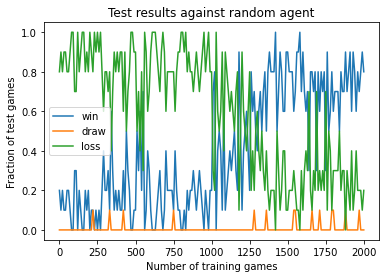

In [4]:
loss_rand = 1-np.array(test_results_rand)-np.array(test_draws_rand)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_rand,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_rand,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_rand,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against random agent');

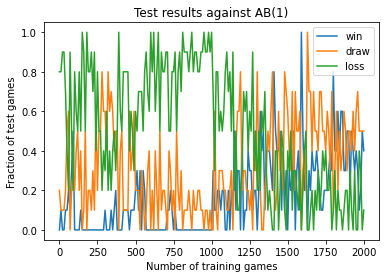

In [5]:
loss_1 = 1-np.array(test_results_1)-np.array(test_draws_1)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_1,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_1,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_1,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(1)');

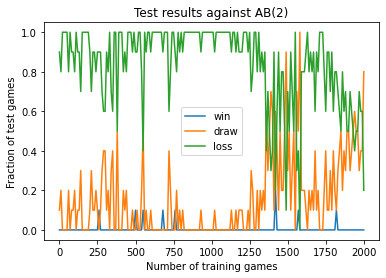

In [6]:
loss_2 = 1-np.array(test_results_2)-np.array(test_draws_2)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_2,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_2,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_2,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(2)');

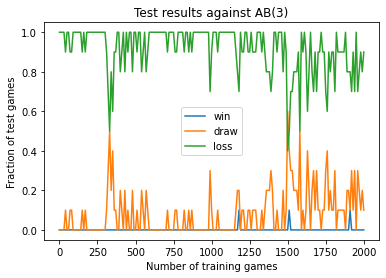

In [7]:
loss_3 = 1-np.array(test_results_3)-np.array(test_draws_3)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_3,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_3,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_3,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(3)');

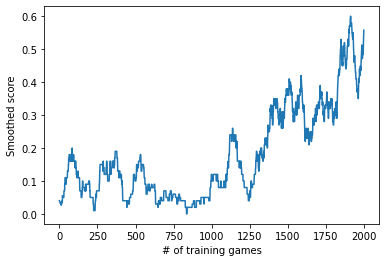

In [8]:
w = 50
calib = np.convolve(np.ones(n_train_games+n_train_games_post_reversal), np.ones(w), 'same')
all_score = 1*np.array(all_results) + 0.5*np.array(all_draws)
mean_smooth_score = np.convolve(all_score, np.ones(w), 'same') / calib
plt.plot(mean_smooth_score)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

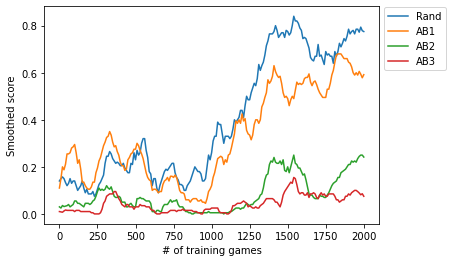

In [9]:
w = 10
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')
all_score_rand = 1*np.array(test_results_rand) + 0.5*np.array(test_draws_rand)
all_score_1 = 1*np.array(test_results_1) + 0.5*np.array(test_draws_1)
all_score_2 = 1*np.array(test_results_2) + 0.5*np.array(test_draws_2)
all_score_3 = 1*np.array(test_results_3) + 0.5*np.array(test_draws_3)
mean_smooth_score_rand = np.convolve(all_score_rand, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_rand, label='Rand')
mean_smooth_score_1 = np.convolve(all_score_1, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_1, label='AB1')
mean_smooth_score_2 = np.convolve(all_score_2, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_2,label='AB2')
mean_smooth_score_3 = np.convolve(all_score_3, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_3,label='AB3')
plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

In [ ]:
w = 100
calib = np.convolve(np.ones(n_train_games+n_train_games_post_reversal), np.ones(w), 'same')

all_mean_smooth_score = []

for i in range(10):
    all_score = 1*np.array(data['pool_results'][i]) + 0.5*np.array(data['pool_draws'][i])
    all_mean_smooth_score.append(np.convolve(all_score, np.ones(w), 'same') / calib)
all_mean_smooth_score_mean = np.mean(np.stack(all_mean_smooth_score),axis=0)
all_mean_smooth_score_sem = np.std(np.stack(all_mean_smooth_score),axis=0)/np.sqrt(10)
plt.plot(range(n_train_games+n_train_games_post_reversal),all_mean_smooth_score_mean)
plt.fill_between(range(n_train_games+n_train_games_post_reversal),all_mean_smooth_score_mean-all_mean_smooth_score_sem, 
                 all_mean_smooth_score_mean+all_mean_smooth_score_sem,alpha=0.3)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

In [ ]:
w = 10
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')

smooth_score_rand = []
smooth_score_1 = []
smooth_score_2 = []
smooth_score_3 = []

for i in range(10):
    all_score_rand = 1*np.array(data['pool_test_results_rand'][i]) + 0.5*np.array(data['pool_test_draws_rand'][i])
    all_score_1 = 1*np.array(data['pool_test_results_1'][i]) + 0.5*np.array(data['pool_test_draws_1'][i])
    all_score_2 = 1*np.array(data['pool_test_results_2'][i]) + 0.5*np.array(data['pool_test_draws_2'][i])
    all_score_3 = 1*np.array(data['pool_test_results_3'][i]) + 0.5*np.array(data['pool_test_draws_3'][i])
    smooth_score_rand.append(np.convolve(all_score_rand, np.ones(w), 'same') / calib)
    smooth_score_1.append(np.convolve(all_score_1, np.ones(w), 'same') / calib)
    smooth_score_2.append(np.convolve(all_score_2, np.ones(w), 'same') / calib)   
    smooth_score_3.append(np.convolve(all_score_3, np.ones(w), 'same') / calib)

smooth_score_rand_mean = np.mean(np.stack(smooth_score_rand),axis=0)
smooth_score_rand_sem = np.std(np.stack(smooth_score_rand),axis=0)/np.sqrt(10)
smooth_score_1_mean = np.mean(np.stack(smooth_score_1),axis=0)
smooth_score_1_sem = np.std(np.stack(smooth_score_1),axis=0)/np.sqrt(10)
smooth_score_2_mean = np.mean(np.stack(smooth_score_2),axis=0)
smooth_score_2_sem = np.std(np.stack(smooth_score_2),axis=0)/np.sqrt(10)
smooth_score_3_mean = np.mean(np.stack(smooth_score_3),axis=0)
smooth_score_3_sem = np.std(np.stack(smooth_score_3),axis=0)/np.sqrt(10)

x = np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency)
plt.plot(x,smooth_score_rand_mean, label='Rand')
plt.fill_between(x,smooth_score_rand_mean-smooth_score_rand_sem, 
                 smooth_score_rand_mean+smooth_score_rand_sem,alpha=0.3)

plt.plot(x,smooth_score_1_mean,label='AB1')
plt.fill_between(x,smooth_score_1_mean-smooth_score_1_sem, 
                 smooth_score_1_mean+smooth_score_1_sem,alpha=0.3)

plt.plot(x,smooth_score_2_mean,label='AB2')
plt.fill_between(x,smooth_score_2_mean-smooth_score_2_sem, 
                 smooth_score_2_mean+smooth_score_2_sem,alpha=0.3)

plt.plot(x,smooth_score_3_mean,label='AB3')
plt.fill_between(x,smooth_score_3_mean-smooth_score_3_sem, 
                 smooth_score_3_mean+smooth_score_3_sem,alpha=0.3)

plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');